In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Distance between PDFs

(a) Cross Entropy (CE):

In [2]:
def entropy(pmf):
    entropy_val = 0

    for p in pmf:
        if p > 0:
            entropy_val += p * np.log2(p)

    return -entropy_val

def kl_divergence(pmf_p, pmf_q):
    divergence = 0

    for p, q in zip(pmf_p, pmf_q):
        if 1 >p > 0 and 1 > q > 0 :
            divergence += p * np.log2(p / q)

    return divergence

def cross_entropy(pmf_p, pmf_q):
    return entropy(pmf_p) + kl_divergence(pmf_p, pmf_q)

In [3]:
def normalized_histogram(image):

    size = len(image)

    histogram = np.zeros(size)

    for row in image:
        for pixel in row:
            intensity = int(pixel * 255)
            histogram[intensity] += 1

    total_pixels = image.shape[0] * image.shape[1]
    normalized_hist = np.array(histogram) / total_pixels

    return normalized_hist

(i)

In [4]:
left_image = plt.imread('left.png')
right_image = plt.imread('right.png')

pmf_left = normalized_histogram(left_image)
pmf_right = normalized_histogram(right_image)

cross_entropy(pmf_left, pmf_right)

7.273398119987328

(ii)

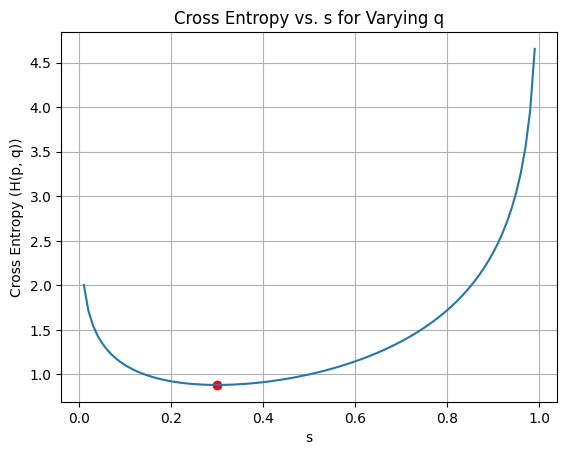

The value of s for which minimum entropy occurs is 0.3 which is equal to r (=0.3)


In [5]:
def bernoulli_pmf(r):
    return np.array([r, 1 - r])

r = 0.3
pmf_p = bernoulli_pmf(r)

s_values = np.arange(0.01, 1, 0.01)

ce_values = []
for s in s_values:
    pmf_q = bernoulli_pmf(s)
    ce = cross_entropy(pmf_p, pmf_q)
    ce_values.append(ce)

idx = np.argmin(ce_values)
min_s = s_values[idx]
min_ce = ce_values[idx]

plt.plot(s_values, ce_values, label="H(p, q)")
plt.scatter(min_s, min_ce, color='red', label='Minimum cross entropy')
plt.xlabel("s")
plt.ylabel("Cross Entropy (H(p, q))")
plt.title("Cross Entropy vs. s for Varying q")
plt.grid(True)
plt.show()

print(f'The value of s for which minimum entropy occurs is {min_s} which is equal to r (=0.3)' )

In [6]:
def JS_divergence(pmf_p, pmf_q):
  pmf_m = (pmf_p + pmf_q)/2
  return kl_divergence(pmf_p, pmf_m) + kl_divergence(pmf_q, pmf_m)

In [7]:
print(JS_divergence(pmf_p, pmf_q))
print(JS_divergence(pmf_q, pmf_p))

0.9148247300785233
0.9148247300785233


From the above values we can verify that Jensen Shannon (JS) Divergence is symmetric as the value obtained after reversing the order is also the same.

In [8]:
print(kl_divergence(pmf_p, pmf_q))
print(kl_divergence(pmf_q, pmf_p))

3.7737583045201477
1.6439485340569304


From the above values we can verify that KL Divergence is not symmetric as the value obtained after reversing the order is not the same.

In [9]:
def validTuple(pmf, rx, sy, tolerance=1e-6):

  rx_actl = np.sum(pmf, axis=1)
  ry_actl = np.sum(pmf, axis=0)

  if np.linalg.norm(rx_actl-rx)<tolerance and np.linalg.norm(ry_actl-sy)<tolerance:
    return True

  if np.linalg.norm(rx_actl-sy)<tolerance and np.linalg.norm(ry_actl-rx)<tolerance:
    return True

  return False


In [10]:
valid_pmf = np.array([[1/4, 1/8, 1/8],
                [1/16, 1/16, 1/8],
                [1/16, 1/16, 1/8]])

invalid_pmf = np.array([[1/4, 1/8, 1/8],
                       [1/16, 1/16, 1/8],
                       [1/16, 1/16, 1/4]])

rx = np.array([3/8, 1/4, 3/8])
sy = np.array([1/2, 1/4, 1/4])

#Positive example
print(validTuple(valid_pmf, rx, sy))

#Negative example
print(validTuple(invalid_pmf, rx, sy))

True
False


# 2. Visualizing Data Using t-SNE:

(a)


**i. What is the crowding problem?**



Crowding problem arises when we are not able to reproduce the distances from high dimension to low dimension. For example, consider the case of a sphere in n-Dimensional space in which data points are approximately uniformly distrubuted. It is not possible to map the distances as the the area available for the same number of data points in a 2-dimension is less than in the n-dimenional.

Hence, points tend to cluster together, failing to accurately reflect their original structure.

**ii. How does the choice of the Student t-distribution in the low dimensional embedding space help address the crowding problem?**

Student t-distribution in low dimension embedding is a heavily-tailed distribution which allows moderately dissimilar datapoints to be placed by a larger distance apart which inturn eliminates the unwanted attractive forces, which doesn't cause the points to cluster up.

But in the case of t-SNE, unlike SNE it has repulsive forces which doesn't allow these points to cluster up.

**iii. What other important changes have been made in t-SNE relative to SNE?**

In t-SNE, the pmf is made symmetric

$ p_{ij} = \frac{p_{i|j} + p_{j|i}}{2n} $

and the similarity between datapoints in high dimensional is modeled using a heavy-tailed student's t-distribution where as SNE uses Gaussian distribution.





(b)

In [107]:
mean1 = np.ones(10)
mean2 = 10 * np.ones(10)

cv = 0.01 * np.identity(10)

cluster1 = np.random.multivariate_normal(mean1, cv, 10)
cluster2 = np.random.multivariate_normal(mean2, cv, 10)

X = np.vstack((cluster1, cluster2))


In [113]:
class tsne:
  def __init__(self, X):
    self.X = X

  def cond_p(self):
    n, x = self.X.shape

    s = 0.4*np.ones(n)
    p = np.zeros((n, n))

    for i in range(n):
      denominator = -1
      for j in range(n):
        denominator += np.exp(-(np.linalg.norm(self.X[i]-self.X[j])**2)/(2*s[i]**2))

      for j in range(n):
        if j ==i:
          continue;
        numerator = np.exp(-(np.linalg.norm(self.X[i]-self.X[j])**2)/(2*s[i]**2))
        p[i,j] = numerator/denominator

    p = (p + p.T)/(2*n)

    return p

  def cond_q(self):
    n, x = self.Y.shape
    q = np.zeros((n, n))

    denominator =0
    for i in range(n):
      for j in range(n):
        if i==j:
          continue
        denominator += (1 + np.linalg.norm(self.Y[i]-self.Y[j])**2)**(-1)

    for i in range(n):
      for j in range(n):
          if j==i:
            continue
          numerator = (1+ np.linalg.norm(self.Y[i]-self.Y[j])**2)**(-1)
          q[i,j] = numerator/denominator
    return q


  def grad(self,p, q):
    n, m = self.Y.shape
    gradient = np.zeros((n, m))
    for i in range(n):
      for j in range(m):
        gradient[i] += 4*(p[i,j]-q[i,j])*(self.Y[i]-self.Y[j])/(1+np.linalg.norm(self.Y[i]-self.Y[j])**2)
    return gradient

  def observations_and_update(self, T, lr, momentum):

    mean = np.zeros(10)
    cov = (1)*np.identity(10)
    n, x = X.shape

    self.Y = np.random.multivariate_normal(mean, cov, n)

    fig, ax = plt.subplots()
    ax.scatter(self.Y[:10,0],self.Y[:10,1], marker = 'o', label = "Class 1")
    ax.scatter(self.Y[10:,0],self.Y[10:,1], marker = 's', label = "Class 2")
    ax.set_title("Before t-SNE")
    ax.legend()

    p = self.cond_p()
    q = self.cond_q()

    print("KL divergence at the beginning is", kl_divergence(p.flatten(), q.flatten()))

    change = self.Y.copy()

    for t in range (T):
      gradient = self.grad(p ,q)
      new_change = lr*gradient + momentum*change
      change =  new_change
      self.Y -= new_change
      q = self.cond_q()

    print("KL divergence at the end of 50 iterations is", kl_divergence(p.flatten(), q.flatten()))

    fig, ax = plt.subplots()
    ax.scatter(self.Y[:10,0],self.Y[:10,1], marker = 'o', label = "Class 1")
    ax.scatter(self.Y[10:,0],self.Y[10:,1], marker = 's', label = "Class 2")
    ax.set_title("After t-SNE")
    ax.legend()


In [ ]:
TSNE = tsne(X)
TSNE.observations_and_update(50, 0.9, 12 )


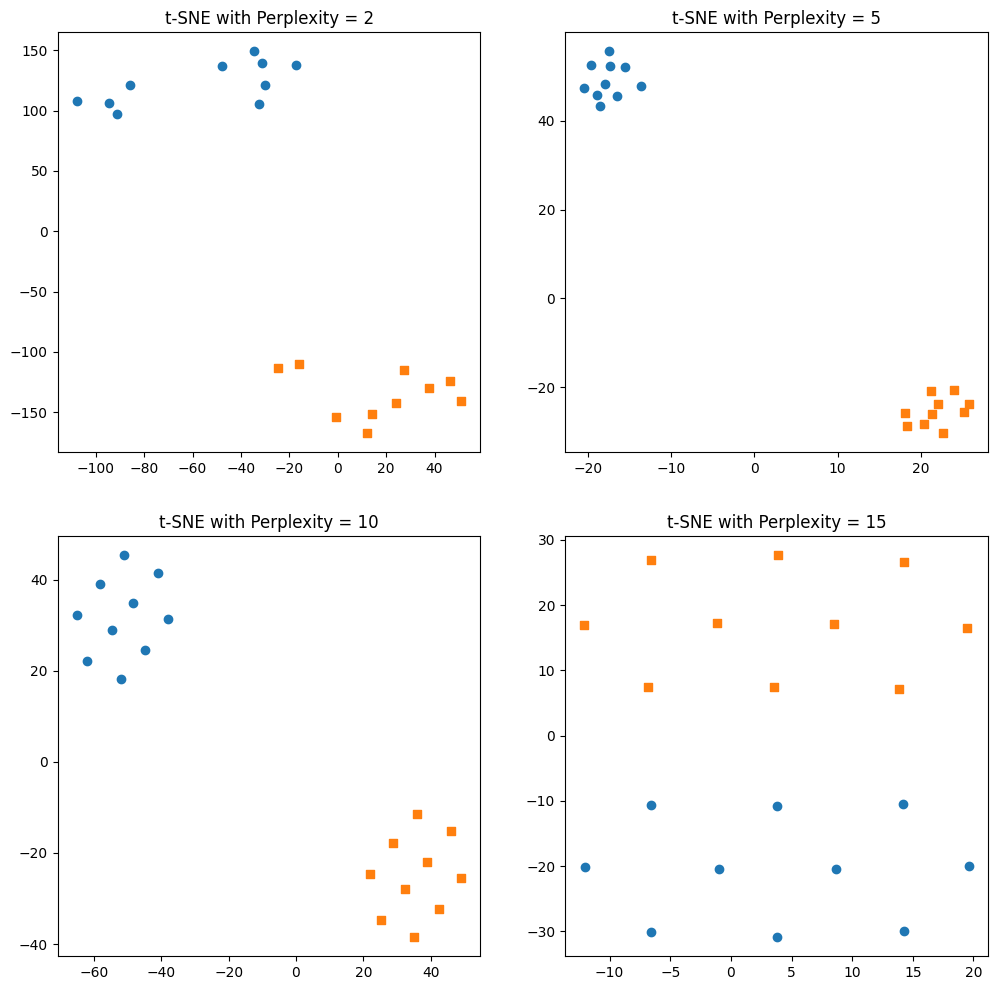

In [88]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

perplexity_values = [2, 5, 10, 15]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.ravel()

for i, perplexity in enumerate(perplexity_values):
    tsne = TSNE(n_components=2, perplexity=perplexity)

    Y = tsne.fit_transform(X)

    axes[i].scatter(Y[:10,0],Y[:10,1], marker='o', label = 'class 1')
    axes[i].scatter(Y[10:,0],Y[10:,1], marker='s', label = 'class 2')
    axes[i].set_title(f't-SNE with Perplexity = {perplexity}')
plt.show()


Low perplexity is used for preserving local structure, tend to form tight clusters in a lower dimension but may lead to crowding in some areas.
For high perplexity the clusters spread out so much that we may not be able to differentiate the clusters
In this case perplexity around 5 would be good enough.